In [75]:
import sys
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
from matplotlib.ticker import AutoMinorLocator
from matplotlib.patches import Patch
from matplotlib.lines import Line2D
from matplotlib.font_manager import FontProperties
import matplotlib as mpl
import seaborn as sns

import pandas as pd
from scipy.optimize import minimize
from tqdm import tqdm

%pip install ahrs
from ahrs.filters.madgwick import Madgwick
from ahrs.filters.mahony import Mahony
from ahrs.filters import EKF
from ahrs.common.orientation import acc2q

file_path = '/home/asp/Downloads/AML/final-project/a000_1/data.hdf5'

Note: you may need to restart the kernel to use updated packages.


In [76]:
mpl.rcParams['text.color'] = 'white'
mpl.rcParams['axes.labelcolor'] = 'white'
mpl.rcParams['xtick.color'] = 'white'
mpl.rcParams['ytick.color'] = 'white'

sns.set_theme()
sns.set_style("darkgrid")
sns.set_context("paper")

def plot_quaternions(loss, dist_metric, agg_type, normal, predictions, tango_ori, time, train_size, network, filename=None):
    fig, ax = plt.subplots(2, 2, figsize=(15, 10))
    fig.suptitle(f'network: {network}, loss: {loss.item():.4f}, dist_metric: {dist_metric}, agg_type: {agg_type}, normalize: {normal}', fontsize=16, color='white')

    legend_elements = [Patch(facecolor='orange', edgecolor='black', label='Predictions on train data'),
                       Patch(facecolor='red', edgecolor='black', label='Predictions on test data'),
                       Patch(facecolor='green', edgecolor='black', label='Orientation from Tango')]

    for i, title in enumerate(['x', 'y', 'z', 'w']):
        ax[i//2, i%2].xaxis.set_minor_locator(AutoMinorLocator())
        ax[i//2, i%2].yaxis.set_minor_locator(AutoMinorLocator())
        if np.linalg.norm(predictions-tango_ori) > np.linalg.norm(predictions+tango_ori):
            predictions = -predictions
        ax[i//2, i%2].plot(time[:train_size], predictions[:train_size, i], color='orange')
        ax[i//2, i%2].plot(time[train_size:], predictions[train_size:, i], color='red')
        ax[i//2, i%2].plot(time, tango_ori[:, i], color='green')
        ax[i//2, i%2].set_title(f'Orientation {title}', color='white')
        ax[i//2, i%2].set_ylabel('Orientation', color='white')
        ax[i//2, i%2].set_xlabel('Time', color='white')
        ax[i//2, i%2].grid(True, which='both', color='gray')
        ax[i//2, i%2].grid(which='minor', alpha=0.2, linestyle='--')
        ax[i//2, i%2].grid(which='major', alpha=0.5)
        ax[i//2, i%2].tick_params(color='white')
        ax[i//2, i%2].xaxis.label.set_color('white')
        ax[i//2, i%2].yaxis.label.set_color('white')
        ax[i//2, i%2].tick_params(axis='x', colors='white')
        ax[i//2, i%2].tick_params(axis='y', colors='white')
        legend = ax[i//2, i%2].legend(handles=legend_elements, title="Legend", loc='upper left', title_fontsize='medium', fontsize='small')
        legend.get_frame().set_facecolor('lightgrey')
        legend.get_frame().set_edgecolor('black')
        legend.get_texts()[0].set_color('black')
        legend.get_title().set_color('black')
    
    fig.patch.set_alpha(0.0)
    plt.tight_layout()

    if filename is not None:
        plt.savefig(f'figures/{filename}.png', dpi=420)
        plt.savefig(f'figures/{filename}.pdf')
        plt.savefig(f'figures/{filename}.svg')

    plt.show()

def plot_quaternion_comparison(Q_1, Q_2, Q_ekf, ekf_ori, tango_ori, q_pred, t, num_elems = 2000, filename=None):
    fig, axs = plt.subplots(2, 2, figsize=(12, 8))
    fig.suptitle('Quaternion Comparison', fontsize=16, color='white')

    legend_elements = [Line2D([0], [0], color='red', lw=2, linestyle='dashed', label='Madgwick'),
                       Line2D([0], [0], color='green', lw=2, linestyle='dashed', label='Mahony'),
                       Line2D([0], [0], color='blue', lw=2, linestyle='dashed', label='EKF'),
                       Line2D([0], [0], color='black', lw=2, label='ekf_ori'),
                       Line2D([0], [0], color='black', lw=2, linestyle='dotted', label='tango_ori'),
                       Line2D([0], [0], color='grey', lw=2, label='q_pred')]

    for i, title in enumerate(['w', 'x', 'y', 'z']):
        axs[i//2, i%2].xaxis.set_minor_locator(AutoMinorLocator())
        axs[i//2, i%2].yaxis.set_minor_locator(AutoMinorLocator())
        axs[i//2, i%2].plot(t[-num_elems:], Q_1[-num_elems:, i], color='red', linestyle='dashed')
        axs[i//2, i%2].plot(t[-num_elems:], Q_2[-num_elems:, i], color='green', linestyle='dashed')
        axs[i//2, i%2].plot(t[-num_elems:], Q_ekf[-num_elems:, i], color='blue', linestyle='dashed')
        axs[i//2, i%2].plot(t[-num_elems:], q_pred[-num_elems:, i], color='grey')
        axs[i//2, i%2].plot(t[-num_elems:], ekf_ori[-num_elems:, i], color='black')
        axs[i//2, i%2].plot(t[-num_elems:], tango_ori[-num_elems:, i], color='black', linestyle='dotted')
        axs[i//2, i%2].set_title(f'Quaternion {title}', color='white')
        axs[i//2, i%2].set_ylabel('Value', color='white')
        axs[i//2, i%2].set_xlabel('Time (s)', color='white')
        axs[i//2, i%2].grid(True, which='both', color='gray')
        axs[i//2, i%2].grid(which='minor', alpha=0.2, linestyle='--')
        axs[i//2, i%2].grid(which='major', alpha=0.5)
        axs[i//2, i%2].tick_params(color='white')
        axs[i//2, i%2].xaxis.label.set_color('white')
        axs[i//2, i%2].yaxis.label.set_color('white')
        axs[i//2, i%2].tick_params(axis='x', colors='white')
        axs[i//2, i%2].tick_params(axis='y', colors='white')
        legend = axs[i//2, i%2].legend(handles=legend_elements, title="Legend", loc='upper left', title_fontsize='medium', fontsize='small')
        legend.get_frame().set_facecolor('lightgrey')
        legend.get_frame().set_edgecolor('black')
        legend.get_texts()[0].set_color('black')
        legend.get_title().set_color('black')
    
    fig.patch.set_alpha(0.0)
    plt.tight_layout()

    if filename is not None:
        plt.savefig(f'figures/{filename}.png', dpi = 420)
        plt.savefig(f'figures/{filename}.pdf')
        plt.savefig(f'figures/{filename}.svg')

    plt.show()


def plot_losses(train_losses, valid_losses, min_epoch, filename=None):
    fig, ax = plt.subplots(figsize=(10, 5))

    ax.plot(train_losses, label='Train loss', color='orange')
    ax.plot(valid_losses, label='Validation loss', color = 'red')
    ax.vlines(min_epoch, 0, max(train_losses), color='black', linestyle='dashed', label='Early stopping')

    ax.set_xlabel('Epochs', color='white')
    ax.set_ylabel('Loss', color='white')
    ax.set_title('Training and Validation Loss', color='white')
    ax.grid(True, which='both', color='gray')
    ax.tick_params(colors='white')
    ax.legend()

    fig.patch.set_alpha(0.0)
    plt.tight_layout()

    if filename is not None:
        plt.savefig(f'figures/{filename}.png', dpi=420)
        plt.savefig(f'figures/{filename}.pdf')
        plt.savefig(f'figures/{filename}.svg')

    plt.show()

CONTENTS OF HDF5 FILE:
pose
	 ekf_ori
		 
	 tango_ori
		 
	 tango_pos
		 
raw
	 imu
		 acce, game_rv, gps, gravity, gyro, gyro_uncalib, linacce, magnet, magnetic_rv, pressure, rv, step, wifi_address, wifi_values
	 tango
		 acce, game_rv, gps, gravity, gyro, gyro_uncalib, linacce, magnet, magnetic_rv, pressure, rv, step, tango_adf_pose, tango_pose, wifi_address, wifi_values
synced
	 acce
		 
	 game_rv
		 
	 grav
		 
	 gyro
		 
	 gyro_uncalib
		 
	 linacce
		 
	 magnet
		 
	 rv
		 
	 time
		 
(10000, 4)
(10000, 3)
(10000, 3)
(10000, 3)
0.005000000001018634


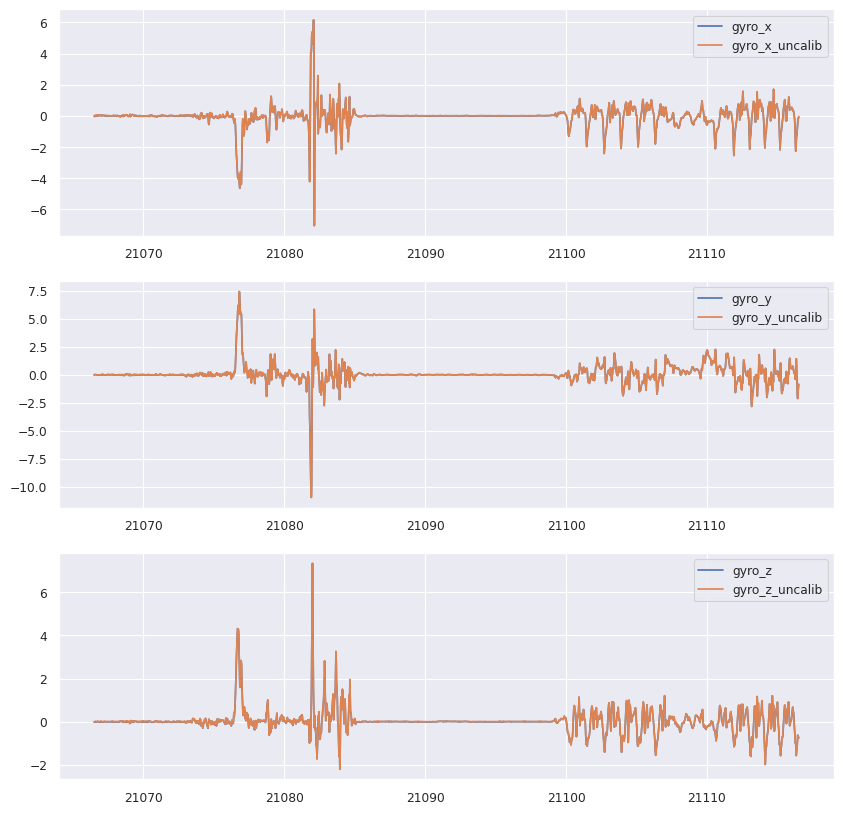

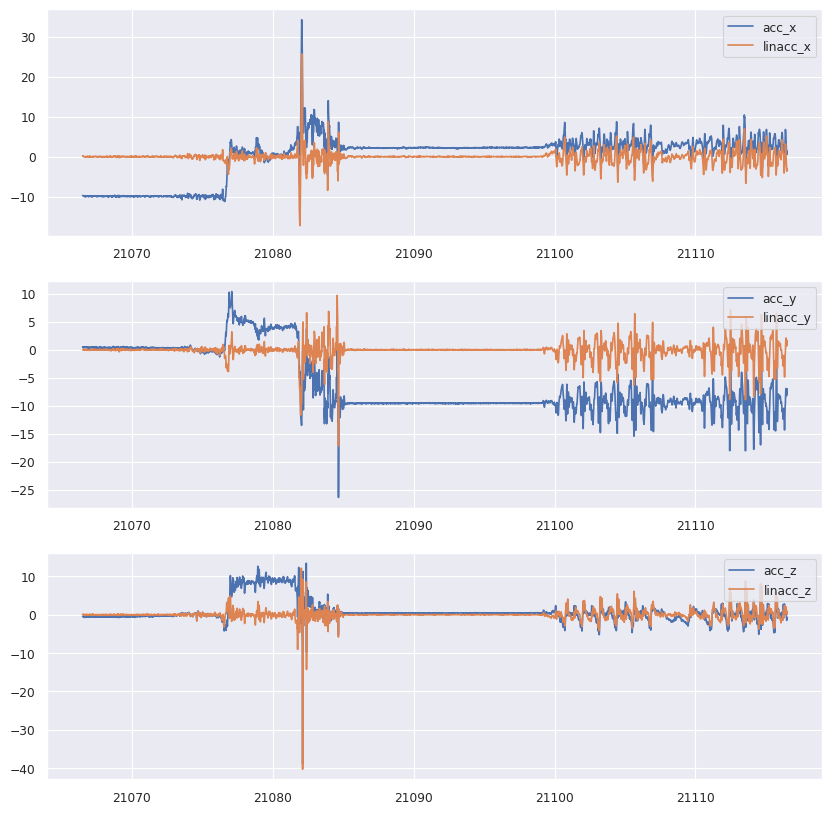

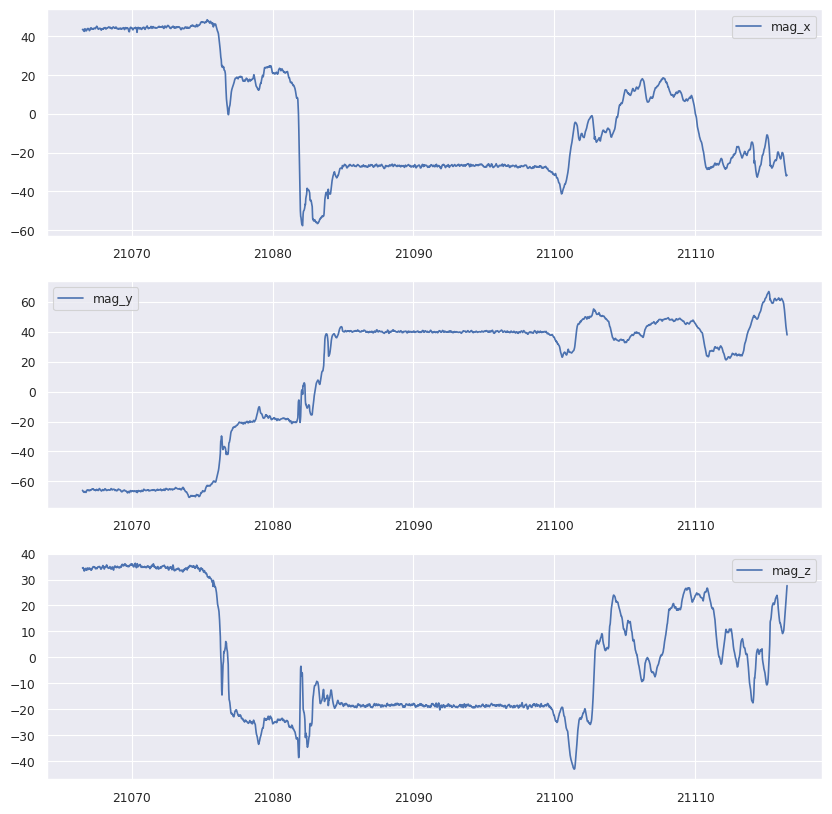

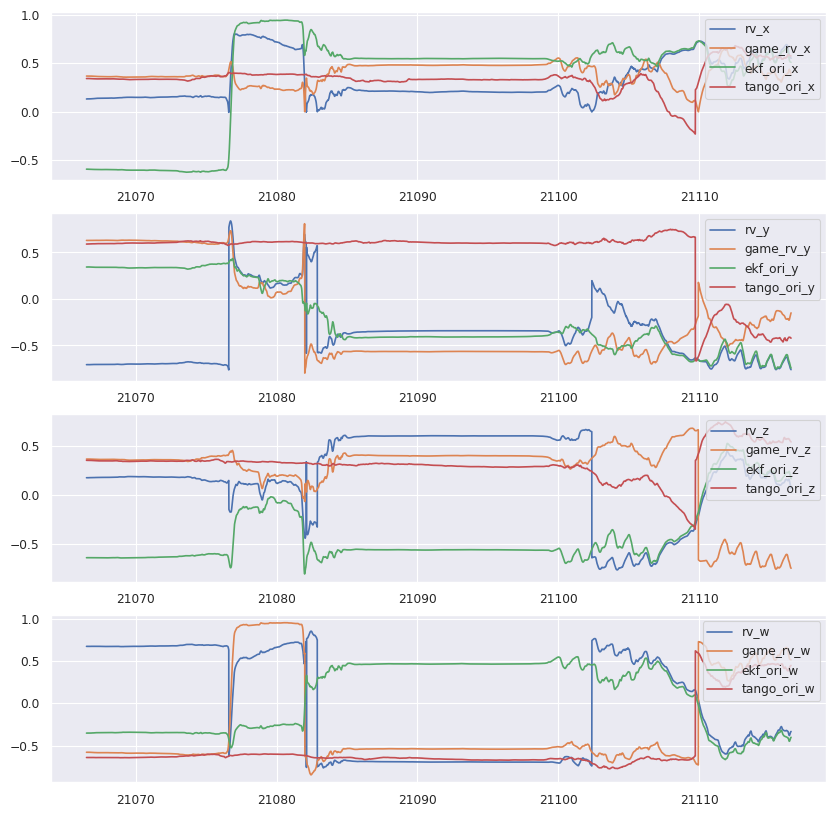

[[-0.58998861  0.34360228 -0.64045332 -0.35166889]
 [-0.59000489  0.34365697 -0.64037418 -0.35173225]
 [-0.59002656  0.34370817 -0.64030011 -0.35178073]
 [-0.59004359  0.34375303 -0.64024558 -0.35180759]
 [-0.5900534   0.34380467 -0.64020469 -0.35181509]
 [-0.59006233  0.34385341 -0.64017243 -0.35181116]
 [-0.59007331  0.34389617 -0.64014876 -0.35179401]
 [-0.59007952  0.34393793 -0.64013661 -0.35176487]
 [-0.59008221  0.34397062 -0.640142   -0.35171859]
 [-0.59009285  0.34399298 -0.64015047 -0.35166346]]


In [77]:
if '..' not in sys.path:
    sys.path.append('../')
from utils import load_data, Theta
data_dict = load_data(file_path, verbose=True)

N = 10000

if N == 0:
    ekf_ori = data_dict['pose/ekf_ori']
    tango_ori = data_dict['pose/tango_ori']
    gyro = data_dict['synced/gyro']
    gyro_uncalib = data_dict['synced/gyro_uncalib']
    acc = data_dict['synced/acce']
    linacc = data_dict['synced/linacce']
    mag = data_dict['synced/magnet']
    num_samples = ekf_ori.shape[0]
    time = data_dict['synced/time']
    rv = data_dict['synced/rv']
    game_rv = data_dict['synced/game_rv']
    diffs = np.diff(time)
    dt = np.mean(diffs)
    q_0 = ekf_ori[0,:]
    
else:
    ekf_ori = data_dict['pose/ekf_ori'][:N]
    tango_ori = data_dict['pose/tango_ori'][:N]
    gyro = data_dict['synced/gyro'][:N]
    gyro_uncalib = data_dict['synced/gyro_uncalib'][:N]
    acc = data_dict['synced/acce'][:N]
    linacc = data_dict['synced/linacce'][:N]
    mag = data_dict['synced/magnet'][:N]
    num_samples = ekf_ori.shape[0]
    time = data_dict['synced/time'][:N]
    rv = data_dict['synced/rv'][:N]
    game_rv = data_dict['synced/game_rv'][:N]
    diffs = np.diff(time)
    dt = np.mean(diffs)
    q_0 = ekf_ori[0,:]

print(ekf_ori.shape)
print(gyro.shape)
print(acc.shape)
print(mag.shape)
print(dt)

fig, ax = plt.subplots(3,1, figsize=(10,10))
ax[0].plot(time, gyro[:,0], label='gyro_x')
ax[0].plot(time, gyro_uncalib[:,0], label='gyro_x_uncalib')
ax[0].legend(loc = 'upper right')
ax[1].plot(time, gyro[:,1], label='gyro_y')
ax[1].plot(time, gyro_uncalib[:,1], label='gyro_y_uncalib')
ax[1].legend(loc = 'upper right')
ax[2].plot(time, gyro[:,2], label='gyro_z')
ax[2].plot(time, gyro_uncalib[:,2], label='gyro_z_uncalib')
ax[2].legend(loc = 'upper right')
plt.show()


fig, ax = plt.subplots(3,1, figsize=(10,10))
ax[0].plot(time, acc[:,0], label='acc_x')
ax[0].plot(time, linacc[:,0], label='linacc_x')
ax[0].legend(loc = 'upper right')
ax[1].plot(time, acc[:,1], label='acc_y')
ax[1].plot(time, linacc[:,1], label='linacc_y')
ax[1].legend(loc = 'upper right')
ax[2].plot(time, acc[:,2], label='acc_z')
ax[2].plot(time, linacc[:,2], label='linacc_z')
ax[2].legend(loc = 'upper right')
plt.show()

fig, ax = plt.subplots(3,1, figsize=(10,10))
ax[0].plot(time, mag[:,0], label='mag_x')
ax[0].legend()
ax[1].plot(time, mag[:,1], label='mag_y')
ax[1].legend()
ax[2].plot(time, mag[:,2], label='mag_z')
ax[2].legend(loc = 'upper right')
plt.show()

fig, ax = plt.subplots(4,1, figsize=(10,10))
ax[0].plot(time, rv[:,0], label='rv_x')
ax[0].plot(time, game_rv[:,0], label='game_rv_x')
ax[0].plot(time, ekf_ori[:,0], label='ekf_ori_x')
ax[0].plot(time, tango_ori[:,0], label='tango_ori_x')
ax[0].legend(loc = 'upper right')
ax[1].plot(time, rv[:,1], label='rv_y')
ax[1].plot(time, game_rv[:,1], label='game_rv_y')
ax[1].plot(time, ekf_ori[:,1], label='ekf_ori_y')
ax[1].plot(time, tango_ori[:,1], label='tango_ori_y')
ax[1].legend(loc = 'upper right')
ax[2].plot(time, rv[:,2], label='rv_z')
ax[2].plot(time, game_rv[:,2], label='game_rv_z')
ax[2].plot(time, ekf_ori[:,2], label='ekf_ori_z')
ax[2].plot(time, tango_ori[:,2], label='tango_ori_z')
ax[2].legend(loc = 'upper right')
ax[3].plot(time, rv[:,3], label='rv_w')
ax[3].plot(time, game_rv[:,3], label='game_rv_w')
ax[3].plot(time, ekf_ori[:,3], label='ekf_ori_w')
ax[3].plot(time, tango_ori[:,3], label='tango_ori_w')
ax[3].legend(loc = 'upper right')
plt.show()

print(ekf_ori[:10,:])

## Find Ideal Parameters

In [78]:
def madgwick_cost(params):
    gain = params[0]
    madgwick_filter = Madgwick(gyr = gyro, acc = acc, mag=mag, dt = dt, q0 = q_0, 
                               gain = gain)
    Q_1 = madgwick_filter.Q
    return np.mean(np.linalg.norm(Q_1 - ekf_ori, axis = 1)**2)

def mahony_cost(params):
    k_P, k_I = params
    mahony_filter = Mahony(gyr = gyro, acc = acc, mag=mag, dt = dt, q0 = q_0,
                           k_P = k_P, k_I = k_I)
    Q_2 = mahony_filter.Q
    return np.mean(np.linalg.norm(Q_2 - ekf_ori, axis = 1)**2)

def ekf_cost(params):
    gyro_var, acc_var, mag_var = params**2
    ekf = EKF(gyr = gyro, acc = acc, mag=mag, dt = dt, q0=q_0, 
              gyro_var = gyro_var, acc_var = acc_var, mag_var=mag_var, frame='ENU')
    Q_ekf = ekf.Q
    return np.mean(np.linalg.norm(Q_ekf - ekf_ori, axis = 1)**2)


# init_guess_madgwick_range = np.geomspace(0.004, .4, 5)
# init_guess_mahony_range = np.geomspace(0.01, 1, 5)
# optimal_loss = np.inf
# optimal_gain = 0

# for init_guess_madgwick in init_guess_madgwick_range:
#     madgwick_result = minimize(madgwick_cost, init_guess_madgwick, tol=1e-3, method='Nelder-Mead')
#     if madgwick_result.fun < optimal_loss:
#         optimal_loss = madgwick_result.fun
#         optimal_gain = init_guess_madgwick
#     print(f"Optimized Gain for Madgwick Filter for {init_guess_madgwick}: ", madgwick_result.x)
#     print("Optimal Parameter: ", optimal_gain)

# optimal_loss_mahony = np.inf
# optimal_k_P = 0
# optimal_k_I = 0
# for init_guess_k_p in init_guess_mahony_range:
#     for init_guess_k_I in init_guess_mahony_range:
#         mahony_result = minimize(mahony_cost, [init_guess_k_p, init_guess_k_I], tol=1e-3, method='Nelder-Mead')
#         if init_guess_k_p + init_guess_k_I > 1:
#             optimal_loss_mahony = mahony_result.fun
#             optimal_k_P = init_guess_k_p
#             optimal_k_I = init_guess_k_I
#         print(f"Optimized k_P and k_I for Mahony Filter for {init_guess_k_p} and {init_guess_k_I}: ", mahony_result.x)
#         print("Optimal Parameters: ", optimal_k_P, optimal_k_I)

# Initial guess
# optimal_gain = [0.5]
# optimal_k = [1, 1]
# init_guess_ekf = [1, 10, 20]
# bounds_ekf = [(0, None), (0, None), (0, None)]

# # Optimization for Madgwick
# madgwick_result = minimize(madgwick_cost, optimal_gain, tol=1e-4, method='Nelder-Mead')
# optimal_gain = madgwick_result.x
# print("Optimized Gain for Madgwick Filter: ", optimal_gain)

# # Optimization for Mahony
# mahony_result = minimize(mahony_cost, optimal_k, tol=1e-4, method='Nelder-Mead')
# optimal_k_P, optimal_k_I = mahony_result.x
# print("Optimized k_P and k_I for Mahony Filter: ", optimal_k_P, optimal_k_I)

# # Optimization for EKF
# ekf_result = minimize(ekf_cost, init_guess_ekf, bounds=bounds_ekf, tol=1e-4)
# optimal_gyro_var, optimal_acc_var, optimal_mag_var = ekf_result.x
# print("Optimized gyro_var and acc_var for EKF: ", optimal_gyro_var, optimal_acc_var, optimal_mag_var)

In [79]:
# Optimized Gain for Madgwick Filter:  1.12666016
# Optimized k_P and k_I for Mahony Filter:   0.5366640716587453 0.4086550384556218
# Optimized gyro_var and acc_var for EKF:  0.3 0.5 0.8

q_0 = np.array([1, 0, 0, 0])

gain = 1.12666016
madgwick_filter = Madgwick(gyr = gyro, acc = acc, mag=mag, dt = dt, q0=q_0, gain=gain)
Q_1 = madgwick_filter.Q

k_P = 0.5366640716587453
k_I = 0.4086550384556218
mahony_filter = Mahony(gyr = gyro, acc = acc, mag=mag, dt = dt, q0=q_0, k_P=k_P, k_I=k_I)
Q_2 = mahony_filter.Q

acc_var = 10
gyro_var = 5
mag_var = 20
ekf = EKF(gyr=gyro, acc=acc, mag=mag, dt = dt, q0=q_0, noises= [gyro_var, acc_var, mag_var])
Q_ekf = ekf.Q

# see if data is normalized
print(np.linalg.norm(Q_1, axis = 1)[:10])
print(np.linalg.norm(Q_2, axis = 1)[:10])
print(np.linalg.norm(Q_ekf, axis = 1)[:10])
print(np.linalg.norm(ekf_ori, axis = 1)[:10])
print(np.linalg.norm(tango_ori, axis = 1)[:10])

[1. 1. 1. 1. 1. 1. 1. 1. 1. 1.]
[1. 1. 1. 1. 1. 1. 1. 1. 1. 1.]
[1. 1. 1. 1. 1. 1. 1. 1. 1. 1.]
[1.00000028 1.00000028 1.00000028 1.00000028 1.00000028 1.00000028
 1.00000028 1.00000028 1.00000028 1.00000028]
[1.00000027 1.00000027 1.00000027 1.00000027 1.00000027 1.00000027
 1.00000027 1.00000027 1.00000027 1.00000027]


## Remove dependency to tango_ori

In [80]:
# Optimized Gain for Madgwick Filter:  1.12666016
# Optimized k_P and k_I for Mahony Filter:   0.5366640716587453 0.4086550384556218
# Optimized gyro_var and acc_var for EKF:  0.3 0.5 0.8

q_0 = np.mean(Q_1[:1000], axis = 0)

gain = 1.12666016
madgwick_filter = Madgwick(gyr = gyro, acc = acc, mag=mag, dt = dt, q0=q_0, gain=gain)
Q_1 = madgwick_filter.Q

q_0 = np.mean(Q_2[:1000], axis = 0)

k_P = 0.5366640716587453
k_I = 0.4086550384556218
mahony_filter = Mahony(gyr = gyro, acc = acc, mag=mag, dt = dt, q0=q_0, k_P=k_P, k_I=k_I)
Q_2 = mahony_filter.Q

q_0 = np.mean(Q_ekf[:1000], axis = 0)

acc_var = 10
gyro_var = 5
mag_var = 20
ekf = EKF(gyr=gyro, acc=acc, mag=mag, dt = dt, q0=q_0, noises= [gyro_var, acc_var, mag_var])
Q_ekf = ekf.Q

In [81]:
w = data_dict['synced/gyro'][:N]
q_gt = data_dict['pose/tango_ori'][:N]
q_pred = np.zeros((len(w), 4))
q_pred[0] = q_gt[0]
factor= .0025
for i in range(1,N):
    q_pred[i] = Theta(w[i]*factor, dt=dt)@q_pred[i-1]

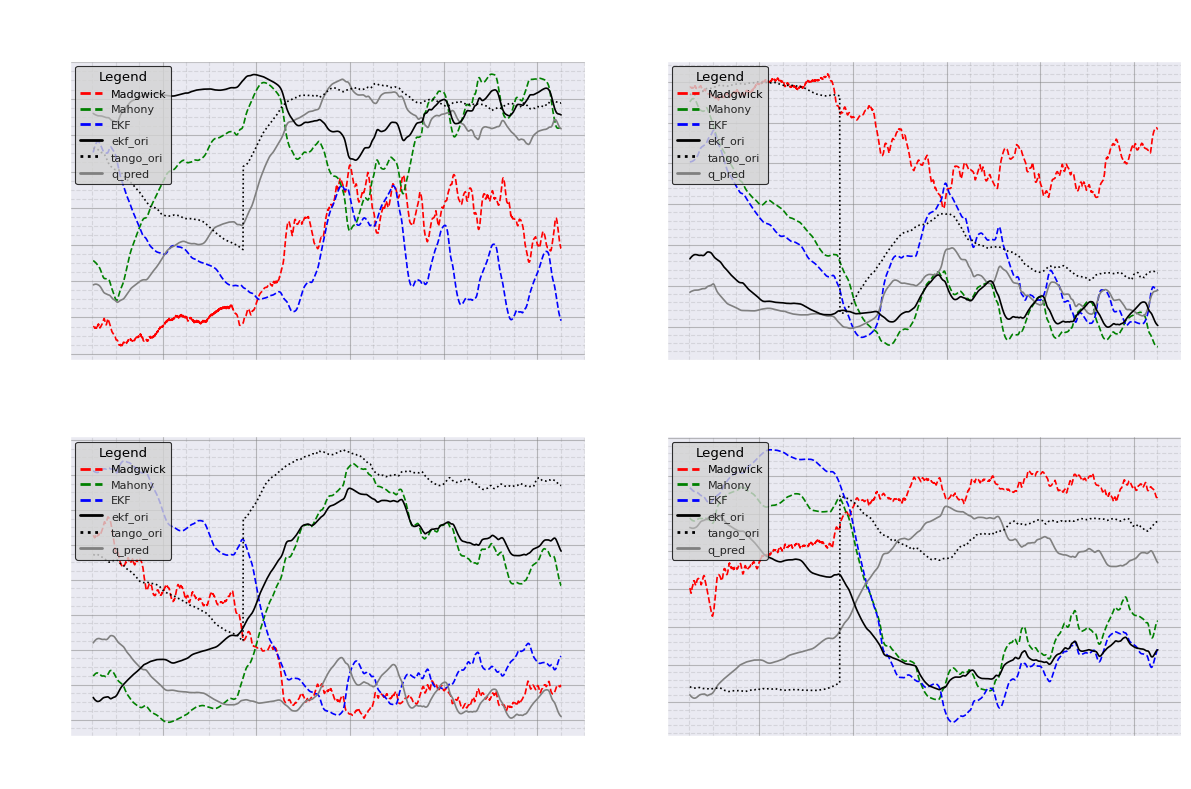

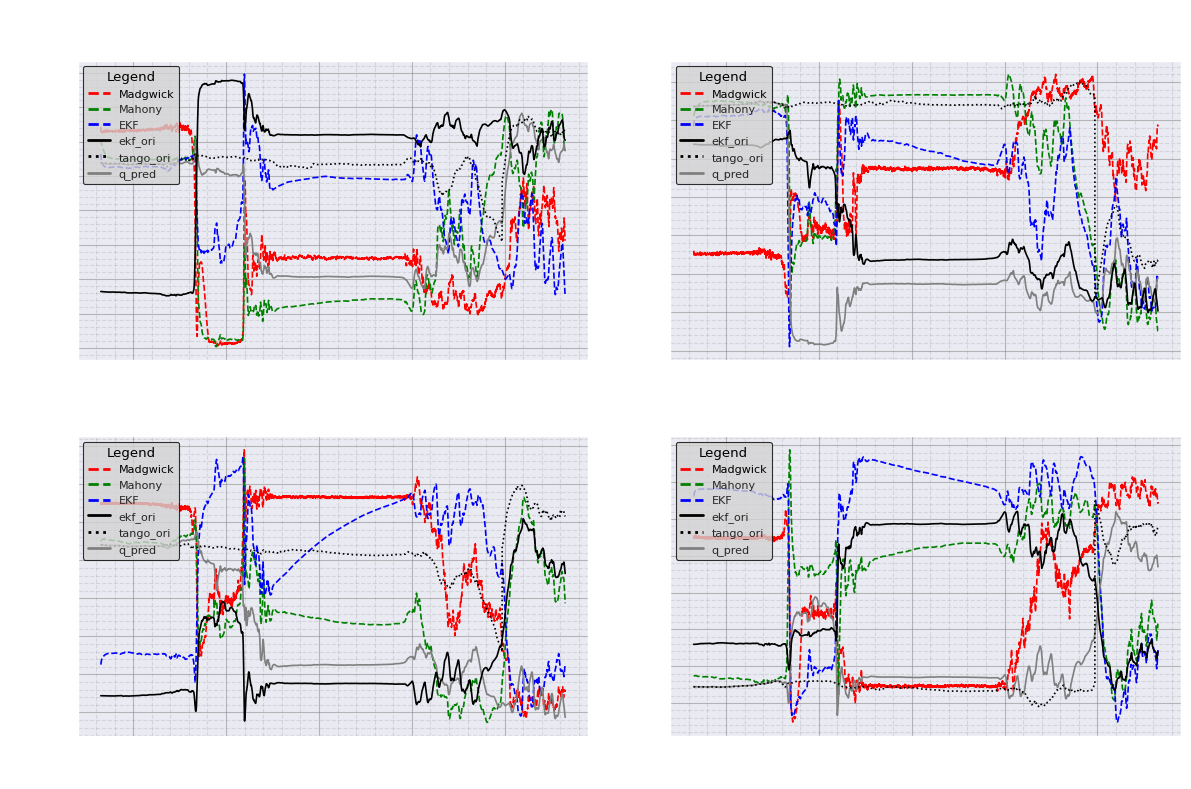

In [82]:
end = time[-1]
start = time[0]
t = np.linspace(start, end+dt, num_samples)

plot_quaternion_comparison(Q_1, Q_2, Q_ekf, ekf_ori, tango_ori, q_pred, t, filename='quaternion_comparison')
plot_quaternion_comparison(Q_1, Q_2, Q_ekf, ekf_ori, tango_ori, q_pred, t, num_elems=10000)